# Data Science | Final Project | Group 02

# Identify epigenetic alterations associated with Alzheimer’s disease and classification of gene expressions between healthy and sick patients

**Christina Kirschbaum, Pushpa Koirala, Melika Moradi**

## Our Project

Alzheimer’s disease is the most prevalent kind of dementia and a fatal brain ailment. More study into this illness might lead to a better understanding of the condition and more effective treatment options. 

In this project, ChIP-seq data for H3K27ac, H3K9ac, H3K122ac and H3K4me1 as well as RNA-seq data from the from the lateral temporal lobe of the human brain for young healthy patients, old heathy patients and patients with Alzheimers disease will be analyzed and the differences between normal aging and cognitive impairment will be explored. The epigenomic or transcriptomic profiles will be analyzed to find relevant epigenetic alterations associated with the disease and help to better understand the molecular pathophysiology underlying.

Afterwards, with Machine Learning models the presence and absence of Alzheimer’s disease based on the data. The models will be built with Support Vector Machines and Random Forest. Additionally, clustering methods will be tested.

Finally, we will look at the functional enrichment of the ChIP-seq data and will add a STRING analysis for the RNA-seq data.

For our project we were inspirated by the paper:
Nativio R, Lan Y, Donahue G et al. ["An integrated multi-omics approach identifies
epigenetic alterations associated with Alzheimer’s disease."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8098004/)

The data is derived from GEO, [Series GSE153875](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE153875), for the CHiP-seq data and the raw RNA-seq data [Series GSE159699](https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA670209&o=acc_s%3Aa). 

For more detailed information about the data, please refer to the README of the repository.

## Data Integration for RNA-seq

In the next step, we import our RNA-seq data from the SubSeries GSE159699 of the SuperSeries GSE153875 with SRA-Toolkit and fastq-dump. To integrate this process into Python, the package subrocess is used.

In [3]:
import subprocess

# sra numbers from accession list of our RNA-seq data from SuperSeries GSE153875 / SubSeries GSE159699
sra_numbers = [
    "SRR12850830", "SRR12850831", "SRR12850832", "SRR12850833", "SRR12850834",
    "SRR12850835", "SRR12850836", "SRR12850837", "SRR12850838", "SRR12850839",
    "SRR12850840", "SRR12850841", "SRR12850842", "SRR12850843", "SRR12850844",
    "SRR12850845", "SRR12850846", "SRR12850847", "SRR12850848", "SRR12850849",
    "SRR12850850", "SRR12850851", "SRR12850852", "SRR12850853", "SRR12850854",
    "SRR12850855", "SRR12850856", "SRR12850857", "SRR12850858", "SRR12850859"
    ]

In [ ]:
# code from https://erilu.github.io/python-fastq-downloader/

# this will download the .sra files to ~/ncbi/public/sra/ 
for sra_id in sra_numbers:
    print ("Currently downloading: " + sra_id)
    prefetch = "prefetch " + sra_id
    print ("The command used was: " + prefetch)
    subprocess.call(prefetch, shell=True)

# this will extract the .sra files from above into a folder named 'fastq'
for sra_id in sra_numbers:
    print ("Generating fastq for: " + sra_id)
    fastq_dump = "fastq-dump --outdir fastq --gzip --skip-technical  --readids --read-filter pass --dumpbase --split-3 --clip ~/ncbi/public/sra/" + sra_id + ".sra"
    print ("The command used was: " + fastq_dump)
    subprocess.call(fastq_dump, shell=True)

## Data Integration for ChIP-seq

The .bed and .bw files for the ChIP-seq data were downloaded. They are available as supplementary files of the SuperSeries GSE153875 from GEO. We split them into folders for H3K27ac, H3K9ac, H3K122ac and H3K4me1 (and peaks) to get smaller sets.

In [ ]:
# The following code can get the metadata (if needed) for the ChIP-seq data with the library GEOparse (similar to GEOquery).
import GEOparse

gse = GEOparse.get_GEO(geo="GSE153875", destdir="./")

In [ ]:
# prints the metadata for the first sample
for gsm_name, gsm in gse.gsms.items():
    print("Name: ", gsm_name)
    print("Metadata:",)
    for key, value in gsm.metadata.items():
        print(" - %s : %s" % (key, ", ".join(value)))
    break

## Preprocessing RNA-seq

### FastQC

For the Quality Control of the RNA-seq data, [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) was downloaded and reports were generated for every sequence. The reports can be found in the repository in the folder MultiQC_RNA.

In [1]:
import subprocess

path = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/"
path_genomeDir = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/GenomeDir/"
path_fastq = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/fastq/"

In [ ]:
# unzip data
for fastq in sra_numbers:
    gunzip = "gunzip " + path_fastq + fastq + "_pass.fastq.gz"
    subprocess.call(gunzip, shell=True)

In [ ]:
for fastq in sra_numbers:
    fastqc = "/home/christina/FastQC/fastqc \
              --readFilesIn " + path_fastq + fastq + "_pass.fastq"
    subprocess.call(fastqc, shell=True)

### STAR

Afterwards, we will now preprocess the data with STAR, an aligner for RNA-seq data mapping. Like in the paper of *Nativio et al.*, we will align our RNA-seq reads to the human reference genome (assembly GRCh37.75/hg19) using [STAR](https://github.com/alexdobin/STAR) with default parameters.
The [fasta](http://ftp.ensembl.org/pub/release-75/fasta/homo_sapiens/dna/) and the [gtf](http://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/) file used for the genomeGenerate run were downloaded from Ensembl. 

This will create .sam files out of the .fastq files. The logfiles for all sequences are saved in the folder MultiQC_RNA.

In [ ]:
# get Genome Index (assembly GRCh37.75)
genomeIndex = "STAR --runThreadN 4 \
               --runMode genomeGenerate \
               --genomeDir " + path_genomeDir + " \
               --genomeFastaFiles " + path + "Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa \
               --sjdbGTFfile " + path + "Homo_sapiens.GRCh37.75.gtf"
subprocess.call(genomeIndex, shell=True)

The logfile for genomeGenerate included many warnings for assembly GRCh37.75/h19, so the most recent version available was taken from Ensembl to check. The [fasta](http://ftp.ensembl.org/pub/release-106/fasta/homo_sapiens/dna/) (primary assembly soft masked) and the [gtf](http://ftp.ensembl.org/pub/release-106/gtf/homo_sapiens/) file can be found following the links.

In the check with the most recent version of GRCh38, the warnings were absent. 
The problem was that the patches, which suggest how gaps in the genome sequence can be filled, are not integrated in the version GRCh37.75/h19, but in the most recent version of GRCh38.

In [ ]:
# get Genome Index (most recent)
genomeIndex = "STAR --runThreadN 4 \
               --runMode genomeGenerate \
               --genomeDir " + path_genomeDir + " \
               --genomeFastaFiles " + path + "Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa \
               --sjdbGTFfile " + path + "Homo_sapiens.GRCh38.106.gtf"
subprocess.call(genomeIndex, shell=True)

To get rid of the warnings, the patches were removed from the assembly and the Genome Index was built with the new file. Due to the removed patches the read count can be distorted because reads that should align to the patches align somewhere else.

The argument `genomeSAindexNbases` was added and set to 12 according to the formula min(14, log2(GenomeLength)/2-1). The value is 14 by default and typically between 10 and 15. Longer strings use more memory but allow faster searches. Also, `genomeSAsparseD` was added and set to 3 because of the memory. This are also the recommended values for 16GB RAM from the inventor of STAR.

In [ ]:
genomeIndex = "STAR --runThreadN 4 \
               --runMode genomeGenerate \
               --genomeDir " + path_genomeDir + " \
               --genomeFastaFiles " + path + "Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa \
               --sjdbGTFfile " + path + "Homo_sapiens.GRCh37.75.without_patch.gtf \
               --genomeSAindexNbases 10"
subprocess.call(genomeIndex, shell=True)

In [ ]:
# Run mapping
for fastq in sra_numbers:
    mapping = "STAR --runThreadN 4 \
               --genomeDir " + path_genomeDir + " \
               --readFilesIn " + path_fastq + fastq + "_pass.fastq \
               --outFileNamePrefix " + path + fastq + "/"
    subprocess.call(mapping, shell=True)

In the end, the STAR process was killed on several computers in the step "... sorting Suffix Array chunks and saving them to disk...". This also happened with `genomeSAindexNbases 10`. We decided to apply a pseudoalignment with kallisto instead, since it needs much less memory.

### kallisto

First of all, we build an index with [kallisto](https://github.com/pachterlab/kallisto) to from the file [Homo_sapiens.GRCh37.75.cdna.all.fa.gz](http://ftp.ensembl.org/pub/release-75/fasta/homo_sapiens/cdna/).

In [4]:
import subprocess

kallistoIndex = "kallisto index -i Homo_sapiens.idx /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/Homo_sapiens.GRCh37.75.cdna.all.fa.gz"
subprocess.call(kallistoIndex, shell=True)


[build] loading fasta file /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/Homo_sapiens.GRCh37.75.cdna.all.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 1401 target sequences
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 1022307 contigs and contains 101446106 k-mers 



0

In the second step, we align all our RNA sequences. Because we want .bam files for featureCounts, the parameters `genomebam` and `gtf` need to be added.

In [2]:
for fastq in sra_numbers:
    kallisto = "(kallisto quant -t 2 --single -l 200 -s 30 \
                --genomebam --gtf /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/Homo_sapiens.GRCh37.75.without_patch.gtf \
                -i Homo_sapiens.idx \
                -o /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/" + fastq + " \
                /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/fastq/" + fastq + "_pass.fastq) \
                2>" + fastq + ".log"
    subprocess.call(kallisto, shell=True)

### featureCounts

Finally, they used featureCounts in the paper. featureCounts is part of the [Subread/RSubread](http://subread.sourceforge.net/) package.

In [9]:
path = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/"

featurecounts = "(/home/christina/subread-2.0.3-Linux-x86_64/bin/featureCounts -T 2 -t exon -g gene_id \
                 -a " + path + "data/Homo_sapiens.GRCh37.75.gtf \
                 -o " + path + "/MultiQC_RNA/counts.txt \
                 " + path + "/data/*.bam) \
                 2> counts.log"
subprocess.call(featurecounts, shell=True)

0

### MultiQC

Now all the generated reports and logfiles for the RNA-seq will be summarized by the tool [MultiQC](https://multiqc.info/).

Note that MultiQC can not run in JupyterLab because JavaScript is blocked and so the figures in the report are not created. Alternatively, it can run in JupyterNotebook or Visual Studio Code. It can also be applied through running the multiqc command in the terminal.

In [ ]:
#multiqc = "multiqc /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/MultiQC_RNA/"
#subprocess.call(multiqc, shell=True)

import multiqc
multiqc.run("/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/MultiQC_RNA/")

## Quality Control ChIP-seq

To get an insight into the quality of the BigWig files which are used for the peak analysis, they were converted to fastq files so that FastQC could be applied. The commands used for the conversion can be found in the following script.

For the `wig2bed` command, the -x was added. `bigWigToWig` generates zero-indexed, half-open WIG files. The option allows to generate coordinate output without reindexing.

The file [hg19.fa](https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/) was downloaded from the link and unzipped before the first usage of bedtools.

The perl script [fasta_to_fastq.pl](https://github.com/ekg/fasta-to-fastq) was downloaded from GitHub.

Afterwards, FastQC was applied and a summary report was created with MultiQC. The reports can be found in the repository.

In [ ]:
from pickle import TRUE
import subprocess

path = '/home/melika/analysis/' 
path_bw= '/home/melika/analysis/H3K4me1/' 


import os

files = os.listdir(path)
for file in files:
    if file.endswith('.gz'):
        files.remove(file) 
files = [x[:-3] if x.endswith('.bw') else x for x in files]


for file in files:
    #bigwig to wig format
    bigwigtowig = "bigWigToWig " + path_bw + file + ".bw " + path_bw + file + ".wig"
    subprocess.call(bigwigtowig,shell=True)

    #wig to bed format
    wigtobed = "wig2bed  < " + path_bw + file + ".wig -x > " + path_bw + file + ".bed"
    subprocess.call(wigtobed, shell=True)

    #bed to fa format using genome reference(hg19.fa)
    getfasta = "bedtools getfasta -fi " + path + "hg19.fa -bed " + path_bw + file + ".bed -fo " + path_bw + file + ".fa"
    subprocess.call(getfasta, shell=True)

    #fa to fq format using perl script
    perl = "perl " + path + "fasta_to_fastq.pl " + path_bw + file + ".fa > " + path_bw + file + ".fq"
    subprocess.call(perl, shell=True)

## Data Analysis ChIP-seq

In the following, parts of the ChIP-seq Analysis can be found. The rest of the analysis is in the R notebook [main_notebook.Rmd](https://github.com/nepsygirl/DataScience_finalProjekt_Group2/blob/main/main_notebook.Rmd) in the repository, in the section ***Data Analysis RNA-seq***.

The Data Analysis for the ChIP-seq data was done with [deeptools](https://deeptools.readthedocs.io/en/develop/). The advantage is that deeptools can directly work with our BigWig files we already have and does not need BAM files.

First, we generate a compressed matrix of values with multiBigwigSummary for all four ChIP-seq datasets.

In [1]:
import subprocess

H3K4me1 = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-3T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-6T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-7T-*.bw \
          -o results_H3K4me1.npz'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-12A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-3T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-6T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-7T-*.bw \
          -o results_H3K9ac.npz'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-12A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-3T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-6T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-7T-*.bw \
          -o results_H3K27ac.npz'
subprocess.call(H3K27ac, shell=True)

H3k122ac = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-7T-*.bw \
          -o results_H3k122ac.npz'
subprocess.call(H3k122ac, shell=True)


The following chromosome names did not match between the bigwig files
chromosome	length
 chrUn_gl000230	     43691
 chrUn_gl000247	     36422
chr8_gl000197_random	     37175
 chrUn_gl000233	     45941
 chrUn_gl000246	     38154
 chrUn_gl000227	    128374
 chrUn_gl000249	     38502
 chrUn_gl000238	     39939
 chrUn_gl000243	     43341
chr21_gl000210_random	     27682
 chrUn_gl000239	     33824
 chrUn_gl000242	     43523
 chrUn_gl000215	    172545
chr17_gl000206_random	     41001
chr19_gl000209_random	    159169
 chrUn_gl000236	     41934
 chrUn_gl000244	     39929
 chrUn_gl000213	    164239
 chrUn_gl000248	     39786
 chrUn_gl000222	    186861
chr8_gl000196_random	     38914
 chrUn_gl000240	     41933
chr18_gl000207_random	      4262
 chrUn_gl000223	    180455
chr9_gl000201_random	     36148
 chrUn_gl000245	     36651
 chrUn_gl000221	    155397
 chrUn_gl000226	     15008
Number of bins found: 309996

The following chromosome names did not match between the bigwig files
chromosome	lengt

0

For all ChIP-seq datasets, correlation heatmaps were plotted with the npz files.

In [8]:
H3K4me1 = 'plotCorrelation --corData results_H3K4me1.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K4me1_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K4me1'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'plotCorrelation --corData results_H3K9ac.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K9ac_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K9ac'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'plotCorrelation --corData results_H3K27ac.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K27ac_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K27ac'
subprocess.call(H3K27ac, shell=True)

H3K122ac = 'plotCorrelation --corData results_H3K122ac.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K122ac_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K122ac'
subprocess.call(H3K122ac, shell=True)

*Warning*. 915803 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 972302 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 875886 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 858371 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting


0

In [9]:
H3K4me1 = 'plotCorrelation --corData results_H3K4me1.npz \
          --corMethod spearman --whatToPlot heatmap \
          --plotFile H3K4me1_heatmap_spearman.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K4me1'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'plotCorrelation --corData results_H3K9ac.npz \
          --corMethod spearman --whatToPlot heatmap \
          --plotFile H3K9ac_heatmap_spearman.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K9ac'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'plotCorrelation --corData results_H3K27ac.npz \
          --corMethod spearman --whatToPlot heatmap \
          --plotFile H3K27ac_heatmap_spearman.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K27ac'
subprocess.call(H3K27ac, shell=True)

H3K122ac = 'plotCorrelation --corData results_H3K122ac.npz \
           --corMethod spearman --whatToPlot heatmap \
           --plotFile H3K122ac_heatmap_spearman.png --plotNumbers\
           --plotTitle CorrelationHeatmapH3K122ac'
subprocess.call(H3K122ac, shell=True)

*Warning*. 915803 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 972302 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 875886 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 858371 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting


0

Additionally, PCA plots were generated for the datasets.

In [11]:
H3K4me1 = 'plotPCA --corData results_H3K4me1.npz \
          --plotFile H3K4me1_pca.png \
          --plotTitle "PCA for H3K4me1"'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'plotPCA --corData results_H3K9ac.npz \
          --plotFile H3K9ac_pca.png \
          --plotTitle "PCA for H3K9ac"'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'plotPCA --corData results_H3K27ac.npz \
          --plotFile H3K27ac_pca.png \
          --plotTitle "PCA for H3K27ac"'
subprocess.call(H3K27ac, shell=True)

H3K122ac = 'plotPCA --corData results_H3K122ac.npz \
           --plotFile H3K122ac_pca.png \
           --plotTitle "PCA for H3K122ac"'
subprocess.call(H3K122ac, shell=True)

*Warning*. 915803 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 972302 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 875886 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 858371 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting


0

## Data Analysis RNA-seq

The Data Analysis for the RNA sequences was done with the R package [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html). It can be found in the R notebook [main_notebook.Rmd](https://github.com/nepsygirl/DataScience_finalProjekt_Group2/blob/main/main_notebook.Rmd) in the repository, in the section ***Data Analysis RNA-seq***.

## Machine Learning

In the following, the generation of the ChIP-seq count matrices and the classification part for the Machine Learning can be found can be found. For the clustering, take a look at the R notebook [main_notebook.Rmd](https://github.com/nepsygirl/DataScience_finalProjekt_Group2/blob/main/main_notebook.Rmd) in the repository, in the section ***Machine Learning***.

### Count matrix for ChIP-seq

Our first approach to generate the count matrices for the ChIP-seq data was to convert the bed files to bam format and create the count matrix from bam files for each modification.

Unfortunately, this did not work. The count matrix files had no header and couldn't be used fot the Machine Learning.

In [ ]:
from pickle import TRUE
import subprocess

path = '/home/melika/analysis/' 
path_bw= '/home/melika/analysis/H3K122ac/' 


import os

files = os.listdir(path)
for file in files:
    if file.endswith('.gz'):
        files.remove(file) 
files = [x[:-4] if x.endswith('.bed') else x for x in files]


for file in files:
    #bed to bam format
    bedToBam = "bedToBam -i " + path + file + ".bed -g " + path + "hg19.txt > " + path + file + ".bam" 
    subprocess.call(bedToBam,shell=True)

    #check the header of bam file
    samtools = "samtools view -H " + path + file + ".bam > " + path + file + ".txt"
    subprocess.call(samtools, shell=True)

    #Because bedtools enforces that each BAM has the same set and order of chromosomes in the BAM headers.
    #replace the header in all bam files, because all bam file should have the same sorted header to create the count matrix
    samtools1 =  "samtools reheader " + path + file + ".txt " + path + file + ".bam > " + path + file + "fixed.bam"
    subprocess.call(samtools1,shell=True)

    #Indexing a sorted bam file enables rapid extraction of alignments that overlap with specific genomic regions.
    #we needed this fixed bams and merged bed files containing the merged peaks to generate the count matrix 
    samtools2 = "samtools index " + path + file + "fixed.bam"
    subprocess.call(samtools2, shell=True)

To be able to use the ChIP-seq data for Machine Learning we generated count matrices for every modification. For this, all bed files for a modification were sorted. Afterwards, the columns for chromosome (column 1), start (column 2), end (column 3) and score (column 5) were extracted. Finally, the count matrix was build with unionbedg from bedtools.

In [2]:
import os
import subprocess

path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/' + sample
    subprocess.call(cut, shell = True)
    
    
H3K4me1 = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-3T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-6T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-3T AD-5T AD-3A AD-5A AD-8T AD-6T AD-7T \
          > H3K4me1_counts.txt'
subprocess.call(H3K4me1, shell=True)

0

In [3]:
path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/' + sample
    subprocess.call(cut, shell = True)

H3K9ac = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-12A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-3T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-6T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-12A Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-3T AD-5T AD-3A AD-5A AD-8T AD-6T AD-7T \
          > H3K9ac_counts.txt'
subprocess.call(H3K9ac, shell=True)

0

In [4]:
path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/' + sample
    subprocess.call(cut, shell = True)

H3K27ac = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-12A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-3T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-6T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-12A Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-3T AD-5T AD-3A AD-5A AD-8T AD-6T AD-7T \
          > H3K27ac_counts.txt'
subprocess.call(H3K27ac, shell=True)

0

In [5]:
path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/' + sample
    subprocess.call(cut, shell = True)

H3k122ac = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-5T AD-3A AD-5A AD-8T AD-7T \
          > H3K122ac_counts.txt'
subprocess.call(H3k122ac, shell=True)

0

### Prepare RNA-seq data

In the following section, we prepare the RNA-seq data for the Machine Learning. 

First of all, we import all the needed librarys and functions.

In [1]:
# Imports
#from google.colab import files 
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from pprint import pprint

import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, r2_score, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs

seed = 7

The following chunk may be needed when running the code in Google Colab, as well as the import `from google.colab import files` in the chunk above.

In [2]:
#pip install pandas==1.0.1
#!pip install git+ssh://git@github.com/pandas-dev/pandas.git@1.0.x

In [3]:
def change_labels(x):
    print(x)
    if 'AD' in x:
        return 1
    return 0

In the next chunks, we import the RNA-seq data from the gene_summary.txt and take a closer look at the dataframe we get.

In [4]:
df = pd.read_csv("data/gene_summary.txt", sep="\t", index_col=0)

In [5]:
print(df.shape)

(27130, 30)


In [6]:
print(df.head(10))

         21-1A-AD  20-1T-AD  23-2A-AD  22-2T-AD  26-3A-AD  24-3T-AD  27-5A-AD  \
refGene                                                                         
SGIP1        1137      1633       900      1398      1257       858       784   
NECAP2        270       261       353       395       326       388       290   
AZIN2         217       300       229       458       258       209       180   
AGBL4         144       139       134       100       136        44        85   
CLIC4         871       770      1067      3641       879       937       751   
SLC45A1       179       306       207       227       220       174       136   
TGFBR3        633       476       746       495       419       365       553   
DBT           532       608       719       517       603       393       387   
PRUNE1        244       254       205       228       281       257       191   
C1orf21      1835      2452      2194      1448      2244      2081      1701   

         25-5T-AD  29-6T-AD

In [7]:
print(df.describe())

            21-1A-AD       20-1T-AD       23-2A-AD       22-2T-AD  \
count   27130.000000   27130.000000   27130.000000   27130.000000   
mean      390.385146     443.332436     424.012459     535.622189   
std      2531.586111    2074.966307    2414.071081    3456.987415   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.000000       2.000000       2.000000   
50%        51.000000      53.000000      59.000000      60.000000   
75%       320.000000     366.000000     360.000000     402.000000   
max    320795.000000  224850.000000  301019.000000  306188.000000   

            26-3A-AD       24-3T-AD       27-5A-AD       25-5T-AD  \
count   27130.000000   27130.000000   27130.000000   27130.000000   
mean      464.482823     411.720015     349.693918     453.947328   
std      2878.542321    3211.355907    2095.245447    4294.041359   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.0000

We transpose the dataframe to get the right form. With the `change_labels` which was defined in the code above, we assign all AD samples to class 1 and all young and old samples to class 0.

In [8]:
df_T = df.T
df_T["class"] = df_T.apply(lambda x: change_labels(x.name), axis=1)

21-1A-AD
20-1T-AD
23-2A-AD
22-2T-AD
26-3A-AD
24-3T-AD
27-5A-AD
25-5T-AD
29-6T-AD
31-7T-AD
28-8T-AD
30-9T-AD
18-10A-Old
11-10T-Old
19-11A-Old
13-11T-Old
15-13T-Old
16-14T-Old
12-6A-Old
14-7A-Old
10-8A-Old
17-9A-Old
2-12A-Young
4-13A-Young
6-14A-Young
8-15A-Young
9-16A-Young
3-17T-Young
5-18T-Young
7-19T-Young


NA values in the dataframe are replaced by 0.

In [9]:
df_T.fillna(0)

refGene,SGIP1,NECAP2,AZIN2,AGBL4,CLIC4,SLC45A1,TGFBR3,DBT,PRUNE1,C1orf21,...,MGC70870,KIR2DL5A,KIR2DS2,KIR2DL2,KIR3DS1,KIR2DS3,KIR2DS5,KIR2DS1,KIR2DL5B,class
21-1A-AD,1137,270,217,144,871,179,633,532,244,1835,...,33,0,0,0,1,0,0,0,0,1
20-1T-AD,1633,261,300,139,770,306,476,608,254,2452,...,15,0,0,0,0,0,0,0,0,1
23-2A-AD,900,353,229,134,1067,207,746,719,205,2194,...,11,0,0,0,0,0,0,0,0,1
22-2T-AD,1398,395,458,100,3641,227,495,517,228,1448,...,31,0,0,0,0,0,0,0,0,1
26-3A-AD,1257,326,258,136,879,220,419,603,281,2244,...,5,0,0,0,1,0,0,0,0,1
24-3T-AD,858,388,209,44,937,174,365,393,257,2081,...,12,0,0,0,0,0,0,0,0,1
27-5A-AD,784,290,180,85,751,136,553,387,191,1701,...,98,0,0,0,0,0,0,0,0,1
25-5T-AD,742,481,522,48,2079,129,196,451,193,1052,...,160,0,0,0,0,0,0,0,0,1
29-6T-AD,1088,329,247,131,700,194,252,455,198,1930,...,35,0,0,0,0,0,0,0,0,1
31-7T-AD,1020,305,266,163,675,216,546,488,245,1968,...,30,0,0,0,0,0,0,0,0,1


We take a look at the distribution of our groups.

In [10]:
df_T.groupby('class').size()

class
0    18
1    12
dtype: int64

Now, we define Y as the labels of our data. We drop the labels from the dataframe for X and change it into a numpy array.

Finally, X and Y are splitted into a train (2/3 of the data) and a test (1/3 of the data) set with the function `train_test_split`.

In [11]:
Y = df_T["class"].values

X = df_T.drop(['class'], axis=1).astype(float).values
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)    

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

In [12]:
X_train

array([[ 0.23523345,  0.26460374, -0.06835483, ...,  0.        ,
         5.38516481,  0.        ],
       [-0.62734648,  0.57040582,  1.60880492, ...,  0.        ,
        -0.18569534,  0.        ],
       [-0.44692638, -0.0794236 ,  0.32627099, ...,  0.        ,
        -0.18569534,  0.        ],
       ...,
       [-0.50191155, -0.42345093, -0.21633951, ...,  0.        ,
        -0.18569534,  0.        ],
       [-0.27853428, -0.1049071 , -0.75895002, ...,  0.        ,
        -0.18569534,  0.        ],
       [ 0.15275569,  2.0739327 , -0.68848113, ...,  0.        ,
        -0.18569534,  0.        ]])

### Random Forest with RNA-seq only

After preparing the RNA-seq data, we nnow want to classify it with a Random Forest.

First, we define the model as `RandomForestClassifier`. Then, we define lists for the parameters `n_estimators` and `max_features` of the model, to give them to `GridSearchCV` and find the combination of parameters that results in the highest accuracy scoring.

In [13]:
model = RandomForestClassifier()

n_estimators = [10, 50, 100, 500, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.825397 using {'max_features': 'log2', 'n_estimators': 500}


We now define the `RandomForestClassifier` with the best parameters found in the `GridSearchCV` and fit the model.

In [14]:
clf_rf = RandomForestClassifier(random_state=43, 
                                n_estimators=grid_result.best_params_.get('n_estimators'), 
                                max_features=grid_result.best_params_.get('max_features'))     
clf_rf.fit(X_train,Y_train)

RandomForestClassifier(max_features='log2', n_estimators=500, random_state=43)

Here, we take a look at the accuracy of the build model.

Then, we generate a confusion matrix to get the true negative, false positive, false negative and true positive. They are respresented in a heatmap from the package seaborn. 

Accuracy is:  0.7


<AxesSubplot:>

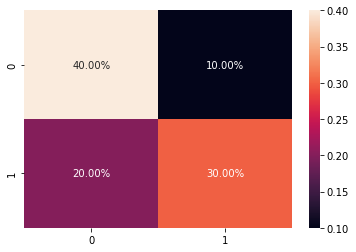

In [15]:
ac = accuracy_score(Y_test,clf_rf.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test,clf_rf.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

In the second chunk, we costumize this heatmap and add labels as well as the absolute number of classified samples for each quadrant for easier readability. 

<AxesSubplot:>

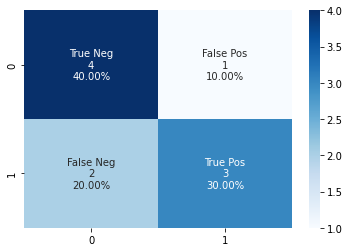

In [16]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

Now, we print a summary report including the precision, accuracy, F1 score, recall and AUC-score for the model.

In [17]:
# get the predictions
y_pred = clf_rf.predict(X_test)

# calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Random Forest with RNA")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('AUC-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Random Forest with RNA
Precision: 0.750
Accuracy: 0.700
F1 Score: 0.667
Recall: 0.600
AUC-score: 0.700


When using a decision tree, the classifier has an attribute `feature_importances_`. We can look at the Top 10 most important features in the following barplot. with an importnace of 0.02, APC2 is the most important feature for Random Forest with RNA.

<AxesSubplot:title={'center':'Feature Importance: Random Forest with RNA'}, ylabel='refGene'>

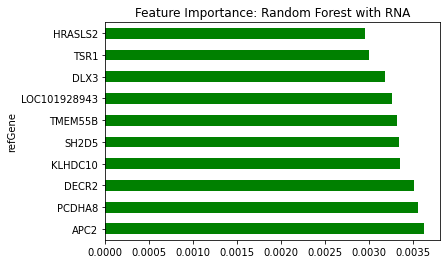

In [18]:
feat_imp = pd.Series(clf_rf.feature_importances_, index = df_T.iloc[:, 1:].columns)
feat_imp.nlargest(10).plot(kind='barh', 
                           color='green',
                           title='Feature Importance: Random Forest with RNA')

### SVM with RNA only

For the SVM model, we apply the same steps as for the Random Forest model accordingly.

In the `GridSearchCV` the parameters `kernel` and `gamma` are tested.

In [19]:
model = sklearn.svm.SVC()

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto'] # for poly, rbf, sigmoid

grid = dict(kernel=kernel, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.865079 using {'gamma': 'scale', 'kernel': 'linear'}


In [20]:
clf_svm = sklearn.svm.SVC(kernel=grid_result.best_params_.get('kernel'), 
                  gamma=grid_result.best_params_.get('gamma'))     
clf_svm.fit(X_train,Y_train)

SVC(kernel='linear')

Accuracy is:  0.8


<AxesSubplot:>

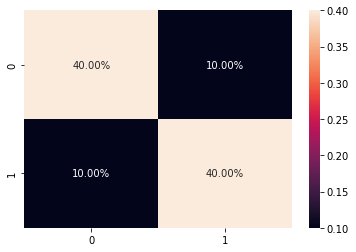

In [21]:
ac = accuracy_score(Y_test,clf_svm.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test, clf_svm.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

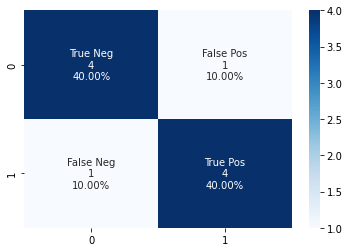

In [22]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [23]:
y_pred = clf_svm.predict(X_test)

conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Support Vector Machine with RNA")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('AUC-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Support Vector Machine with RNA
Precision: 0.800
Accuracy: 0.800
F1 Score: 0.800
Recall: 0.800
AUC-score: 0.800


In the following, we are generating a plot that compares the ROC curves for the Random Forest and SVM model with the RNA data. It visualizes that the SVM model has a higher AUC score and classified better therefore. Additionally, in the summary report SVM surpassed Random Forest for all values we looked at.

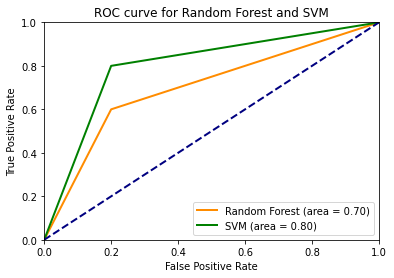

In [24]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, clf_rf.predict(X_test), pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(Y_test, clf_svm.predict(X_test), pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2,
         label="Random Forest (area = %0.2f)" % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color="green", lw=2,
         label="SVM (area = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest and SVM")
plt.legend(loc="lower right")
plt.show()

Because we are classifying with a linear SVM here, we can use the attribute `coef_` to take a look at the feature importance. On the plot we can see the values for the Top 10 most important features. Since we have many features in our model, the importance of every feature is relatively small.

<AxesSubplot:title={'center':'Feature Importance: SVM with RNA'}, ylabel='refGene'>

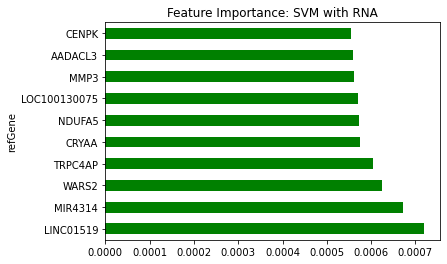

In [25]:
feat_imp = pd.Series(list(clf_svm.coef_[0]), index = df_T.iloc[:, 1:].columns)
feat_imp.nlargest(10).plot(kind='barh', 
                           color='green',
                           title='Feature Importance: SVM with RNA')

### Preparing ChIP-seq data

First, we load the ChIP-seq count matrix. The file can be found under the Google Drive link in the README.

In [26]:
df = pd.read_csv("data/H3K122ac_counts.txt", sep="\t")

Now, we look at the form of our dataframe.

In [27]:
print(df.shape)
print(df.head(10))

(2240520, 30)
  chrom   start     end  Y-15T  Y-17T  Y-13A  Y-18T  Y-14A  Y-19T  Y-15A  ...  \
0  chr1  713810  713860      0      0      0      0      0      0      0  ...   
1  chr1  713860  713861      0      0      0      0      0      0      0  ...   
2  chr1  713861  713882      0      0      0      0      0      0      0  ...   
3  chr1  713882  713885      0      0      0      0      0      0      0  ...   
4  chr1  713885  713891      0      0      0      0      0      0      0  ...   
5  chr1  713891  713904      0      0      0      0      0      0      0  ...   
6  chr1  713904  713938      0      0      0      0      0      0      0  ...   
7  chr1  713938  713944      0      0      0      0      0      0      0  ...   
8  chr1  713944  713949      0      0      0      0      0     21      0  ...   
9  chr1  713949  713973      0      0      0      0      0     21      0  ...   

   O-11A  AD-1T  AD-1A  AD-2T  AD-2A  AD-5T  AD-3A  AD-5A  AD-8T  AD-7T  
0      0      0     

To get the right form for our dataframe, we combine the columns `chrom`, `start` and `end` into a single one. After that, we can drop the columns for `start` and `end` and use the merged `chrom`column as index.

In [28]:
df['chrom'] = df['chrom'] + ' ' + df['start'].astype(str) + '-' + df['end'].astype(str)
df = df.drop('start', axis=1)
df = df.drop('end', axis=1)
df = df.set_index('chrom')
print(df.head(10))

                    Y-15T  Y-17T  Y-13A  Y-18T  Y-14A  Y-19T  Y-15A  Y-16A  \
chrom                                                                        
chr1 713810-713860      0      0      0      0      0      0      0      0   
chr1 713860-713861      0      0      0      0      0      0      0      0   
chr1 713861-713882      0      0      0      0      0      0      0      0   
chr1 713882-713885      0      0      0      0      0      0      0      0   
chr1 713885-713891      0      0      0      0      0      0      0      0   
chr1 713891-713904      0      0      0      0      0      0      0      0   
chr1 713904-713938      0      0      0      0      0      0      0      0   
chr1 713938-713944      0      0      0      0      0      0      0      0   
chr1 713944-713949      0      0      0      0      0     21      0      0   
chr1 713949-713973      0      0      0      0      0     21      0      0   

                    O-8A  O-10T  ...  O-11A  AD-1T  AD-1A  AD-2

Again, the dataframe is transposed and `change_labels` assigns all AD samples to class 1 and all young and old samples to class 0.

In [29]:
df_T = df.T
df_T["class"] = df_T.apply(lambda x: change_labels(x.name), axis=1)

Y-15T
Y-17T
Y-13A
Y-18T
Y-14A
Y-19T
Y-15A
Y-16A
O-8A
O-10T
O-6A
O-11T
O-7A
O-13T
O-14T
O-9A
O-10A
O-11A
AD-1T
AD-1A
AD-2T
AD-2A
AD-5T
AD-3A
AD-5A
AD-8T
AD-7T


NA values are replaced with 0.

In [30]:
df_T.fillna(0)

chrom,chr1 713810-713860,chr1 713860-713861,chr1 713861-713882,chr1 713882-713885,chr1 713885-713891,chr1 713891-713904,chr1 713904-713938,chr1 713938-713944,chr1 713944-713949,chr1 713949-713973,...,chrY 22738064-22738088,chrY 22738088-22738113,chrY 22738113-22738235,chrY 22738235-22738243,chrY 23764353-23764935,chrY 23764935-23765114,chrY 23765114-23765197,chrY 23765197-23765201,chrY 23765201-23765332,class
Y-15T,0,0,0,0,0,0,0,0,0,0,...,20,20,20,0,16,16,16,0,0,0
Y-17T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,20,20,0
Y-13A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-18T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-14A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-19T,0,0,0,0,0,0,0,0,21,21,...,0,0,0,0,0,0,0,0,0,0
Y-15A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-16A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O-8A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O-10T,0,0,0,0,0,16,16,16,16,16,...,0,0,0,0,0,0,0,0,0,0


We take a look at the distribution of the classes. In the ChIP-seq datasets, there are mostly not all 30 samples available.

In [31]:
df_T.groupby('class').size()

class
0    18
1     9
dtype: int64

We again define X and Y and split them into train and test sets.

In [32]:
Y = df_T["class"].values

X = df_T.drop(['class'], axis=1).astype(float).values
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

In [33]:
X_train

array([[-0.19611614, -0.27095596, -0.32111514, ..., -0.34836651,
        -0.28158883, -0.19611614],
       [-0.19611614, -0.27095596, -0.32111514, ..., -0.34836651,
        -0.28158883, -0.19611614],
       [-0.19611614, -0.27095596, -0.32111514, ..., -0.34836651,
        -0.28158883, -0.19611614],
       ...,
       [-0.19611614, -0.27095596, -0.32111514, ...,  3.41399177,
         3.86544662, -0.19611614],
       [-0.19611614, -0.27095596, -0.32111514, ..., -0.34836651,
        -0.28158883, -0.19611614],
       [-0.19611614, -0.27095596, -0.32111514, ..., -0.34836651,
        -0.28158883, -0.19611614]])

In [34]:
Y_train

array([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])

### Random Forest with ChIP-seq only

The following steps are like for the Random Forest with RNA-seq.

In [35]:
model = RandomForestClassifier()

n_estimators = [10, 50, 100, 500, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.574074 using {'max_features': 'log2', 'n_estimators': 10}


In [36]:
clf_rf = RandomForestClassifier(random_state=43, 
                                n_estimators=grid_result.best_params_.get('n_estimators'), 
                                max_features=grid_result.best_params_.get('max_features'))     
clf_rf.fit(X_train,Y_train)

RandomForestClassifier(max_features='log2', n_estimators=10, random_state=43)

Accuracy is:  0.6666666666666666


<AxesSubplot:>

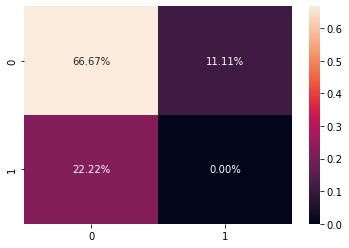

In [37]:
ac = accuracy_score(Y_test,clf_rf.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test,clf_rf.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

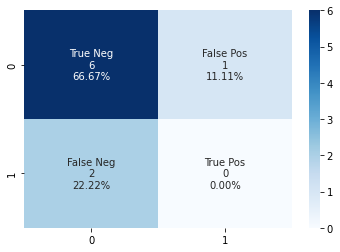

In [38]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [39]:
# Get the predictions
y_pred = clf_rf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)
print()
print("Summary: Random Forest with ChIP-seq")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('AUC-score: %.3f' % roc_auc_score(Y_test, y_pred))


Summary: Random Forest with ChIP-seq
Precision: 0.000
Accuracy: 0.667
F1 Score: 0.000
Recall: 0.000
AUC-score: 0.429


### SVM with ChIP-seq only

The following steps are like for the SVM with RNA-seq.

In [40]:
model = sklearn.svm.SVC()

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto'] # for poly, rbf, sigmoid

grid = dict(kernel=kernel, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.611111 using {'gamma': 'scale', 'kernel': 'poly'}


In [41]:
clf_svm = sklearn.svm.SVC(kernel=grid_result.best_params_.get('kernel'), 
                          gamma=grid_result.best_params_.get('gamma'))     
clf_svm.fit(X_train,Y_train)

SVC(kernel='poly')

Accuracy is:  0.7777777777777778


<AxesSubplot:>

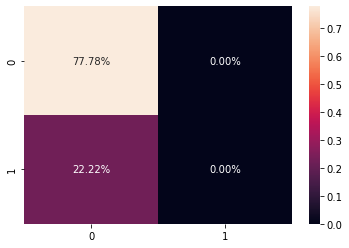

In [42]:
ac = accuracy_score(Y_test,clf_svm.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test, clf_svm.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

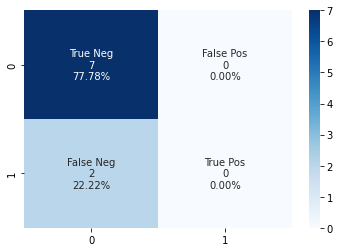

In [43]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [44]:
# Get the predictions
y_pred = clf_svm.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Support Vector Machine with ChIP-seq")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('AUC-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Support Vector Machine with ChIP-seq
Precision: 0.000
Accuracy: 0.778
F1 Score: 0.000
Recall: 0.000
AUC-score: 0.500


/home/christina/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In the following, we are generating a plot that compares the ROC curves for the Random Forest and SVM model with the RNA data. It shows that for the ChIP-seq data SVM has the better AUC score. Overall, the models did not perform very well on the ChIP-seq dataset tested. The AUC score for SVM implies that it is only as good as a random classification, while Random Forest is even worse than a random classification and is more likely to classify the samples wrong. 

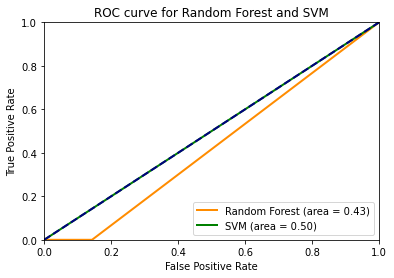

In [45]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, clf_rf.predict(X_test), pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(Y_test, clf_svm.predict(X_test), pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2,
         label="Random Forest (area = %0.2f)" % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color="green", lw=2,
         label="SVM (area = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest and SVM")
plt.legend(loc="lower right")
plt.show()

As we realized, when searching for the parameters with the best accuracy, our model only predicts for the negative class and precision, recall, and F1 score are 0. Therefore, we searched for parameters that maximize the F1 score in the following section.

In [46]:
model = sklearn.svm.SVC()

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto'] # for poly, rbf, sigmoid

grid = dict(kernel=kernel, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.055556 using {'gamma': 'scale', 'kernel': 'linear'}


In [47]:
clf_svm = sklearn.svm.SVC(kernel=grid_result.best_params_.get('kernel'), 
                          gamma=grid_result.best_params_.get('gamma'))     
clf_svm.fit(X_train,Y_train)

SVC(kernel='linear')

Accuracy is:  0.8888888888888888


<AxesSubplot:>

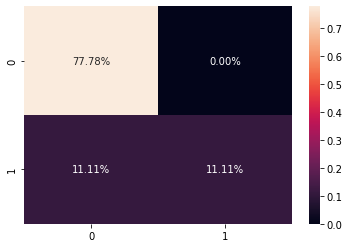

In [48]:
ac = accuracy_score(Y_test,clf_svm.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test, clf_svm.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

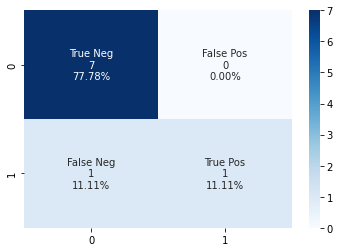

In [49]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [50]:
# Get the predictions
y_pred = clf_svm.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Support Vector Machine with ChIP-seq")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('AUC-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Support Vector Machine with ChIP-seq
Precision: 1.000
Accuracy: 0.889
F1 Score: 0.667
Recall: 0.500
AUC-score: 0.750


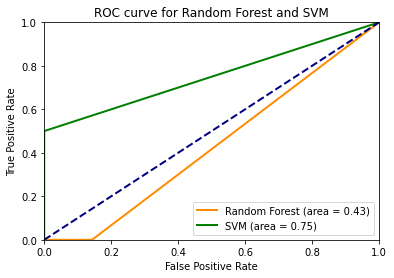

In [51]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, clf_rf.predict(X_test), pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(Y_test, clf_svm.predict(X_test), pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2,
         label="Random Forest (area = %0.2f)" % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color="green", lw=2,
         label="SVM (area = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest and SVM")
plt.legend(loc="lower right")
plt.show()

This shows, that the SVM model does get better when we maximize for the parameters. 